In [1]:
import pandas as pd
pd.set_option("display.max_columns", 150)
import glob
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
#importing the data
csv_files = glob.glob('../data/trips2/*.csv')


dataframes = []


for csv_file in csv_files:
    df = pd.read_csv(csv_file, low_memory=False)
    dataframes.append(df)

citibike = pd.concat(dataframes, ignore_index=True)


citibike  = citibike.drop(columns = 'Unnamed: 0') #dropping extra column
citibike = citibike.sort_values('date').reset_index(drop = True) #sorting the values by date and resetting index.

In [3]:
#changing columns to datetime.
citibike['date'] = pd.to_datetime(citibike['date'])
citibike['year'] = pd.to_datetime(citibike['date']).dt.year
citibike['month'] = pd.to_datetime(citibike['date']).dt.month
citibike['day_of_week'] = citibike['day_of_week'].astype(str) #changing the day of week column to string.
citibike['is_snow'] = citibike['snow'] != 0
citibike['did_rain'] = citibike['prcp'] != 0

In [4]:
#creating a column that has the seasons.
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

citibike['season'] = citibike['date'].apply(get_season)

In [5]:
citibike

,date,num_of_trips,holiday,prcp,snow,awnd,rhav,rhmn,rhmx,tmax,tmin,tavg,median_trip_duration,mean_trip_duration,day_of_week,year,month,is_snow,did_rain,season
0,2019-01-01,21962,True,15,0.0,NaN,69.0,47.0,97.0,57.92,39.02,48.47,663.0,1175.93,1,2019,1,False,True,Winter
1,2019-01-02,37797,False,0,0.0,NaN,56.0,48.0,68.0,39.92,35.06,37.49,548.0,780.93,2,2019,1,False,False,Winter
2,2019-01-03,41676,False,0,0.0,NaN,63.0,43.0,83.0,44.06,37.04,40.55,533.0,769.52,3,2019,1,False,False,Winter
3,2019-01-04,43922,False,0,0.0,NaN,63.0,51.0,74.0,46.94,35.06,41.00,535.0,778.15,4,2019,1,False,False,Winter
4,2019-01-05,17432,False,127,0.0,NaN,91.0,71.0,97.0,46.94,41.00,43.97,476.0,811.47,5,2019,1,False,True,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2021-12-27,31579,False,23,0.0,20.0,63.0,51.0,93.0,39.02,33.98,36.50,511.0,1453.05,0,2021,12,False,True,Winter
1091,2021-12-28,40723,False,13,0.0,21.0,72.0,51.0,96.0,46.94,35.96,41.45,574.0,1614.95,1,2021,12,False,True,Winter
1092,2021-12-29,39649,False,36,0.0,26.0,90.0,85.0,93.0,44.06,41.00,42.53,558.0,1450.66,2,2021,12,False,True,Winter
1093,2021-12-30,46916,False,13,0.0,11.0,87.0,80.0,97.0,48.92,42.98,45.95,587.0,1507.61,3,2021,12,False,True,Winter


In [6]:
citibike['median_trip_duration'].mean()

673.327397260274

In [7]:
events = {
    'date': ['2019-06-30', '2021-07-27', '2019-03-16', '2019-06-09', '2020-06-14', '2021-06-13'],
    'nyc_event': ['nyc_pride_parade_2019', 'nyc_pride_parade_2021', "st.patrick's_day_parade_2019", 
                  'pr_day_parade_2019', 'pr_day_parade_2020', 'pr_day_parade_2021']
}

events = pd.DataFrame(events)

In [8]:
events['date'] = pd.to_datetime(events['date'])

citibike = pd.merge(citibike, events, on='date', how='left')

# Create a binary column whether an event happened or not
citibike['event_happened'] = citibike['nyc_event'].notnull()

# Drop column
citibike = citibike.drop(columns=['nyc_event'])


In [9]:
#checking the total amount of trips by year. 
citibike.groupby('year')['num_of_trips'].sum().sort_values(ascending = False)

year
2021    27648252
2019    20551697
2020    19506857
Name: num_of_trips, dtype: int64

In [10]:
#checking the total amount of trips by day of week. 
citibike.groupby('day_of_week')['num_of_trips'].sum().sort_values(ascending = False)

day_of_week
2    10116050
5    10016764
1     9984289
4     9914074
3     9733053
0     9158835
6     8783741
Name: num_of_trips, dtype: int64

In [11]:
#checking the median trip duration by day of week. 
citibike.groupby('day_of_week')['median_trip_duration'].median().sort_values(ascending = False)

day_of_week
5    758.0
6    722.0
4    646.0
0    624.0
1    621.5
2    617.0
3    604.0
Name: median_trip_duration, dtype: float64

In [12]:
#checking the total amount of trips by season. 
citibike.groupby('season')['num_of_trips'].sum().sort_values(ascending = False)

season
Summer    22301805
Fall      20996908
Spring    14572752
Winter     9835341
Name: num_of_trips, dtype: int64

In [13]:
#checking the total amount of trips by season. 
citibike.groupby('season')['median_trip_duration'].median().reset_index()

,season,median_trip_duration
0,Fall,641.0
1,Spring,673.0
2,Summer,725.0
3,Winter,535.5


In [14]:
citibike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 0 to 1094
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1095 non-null   datetime64[ns]
 1   num_of_trips          1095 non-null   int64         
 2   holiday               1095 non-null   bool          
 3   prcp                  1095 non-null   int64         
 4   snow                  1095 non-null   float64       
 5   awnd                  972 non-null    float64       
 6   rhav                  1084 non-null   float64       
 7   rhmn                  1084 non-null   float64       
 8   rhmx                  1084 non-null   float64       
 9   tmax                  1095 non-null   float64       
 10  tmin                  1095 non-null   float64       
 11  tavg                  1095 non-null   float64       
 12  median_trip_duration  1095 non-null   float64       
 13  mean_trip_duration

In [15]:
citibike.columns

Index(['date', 'num_of_trips', 'holiday', 'prcp', 'snow', 'awnd', 'rhav',
       'rhmn', 'rhmx', 'tmax', 'tmin', 'tavg', 'median_trip_duration',
       'mean_trip_duration', 'day_of_week', 'year', 'month', 'is_snow',
       'did_rain', 'season', 'event_happened'],
      dtype='object')

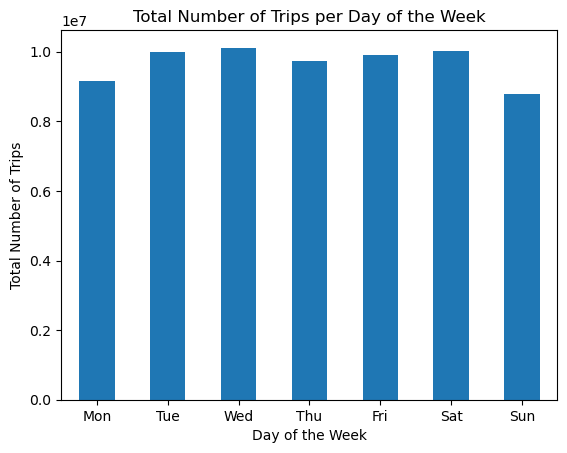

In [16]:
citibike.groupby('day_of_week')['num_of_trips'].sum().plot.bar()


plt.title('Total Number of Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Number of Trips')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation = 0)


plt.show()

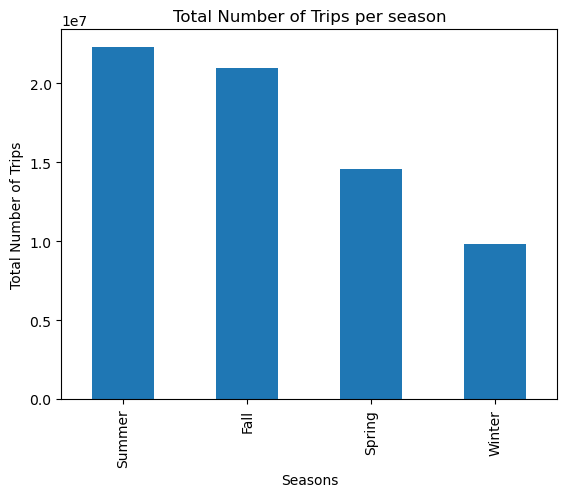

In [17]:
citibike.groupby('season')['num_of_trips'].sum().sort_values(ascending = False).plot.bar()


plt.title('Total Number of Trips per season')
plt.xlabel('Seasons')
plt.ylabel('Total Number of Trips')


plt.show()

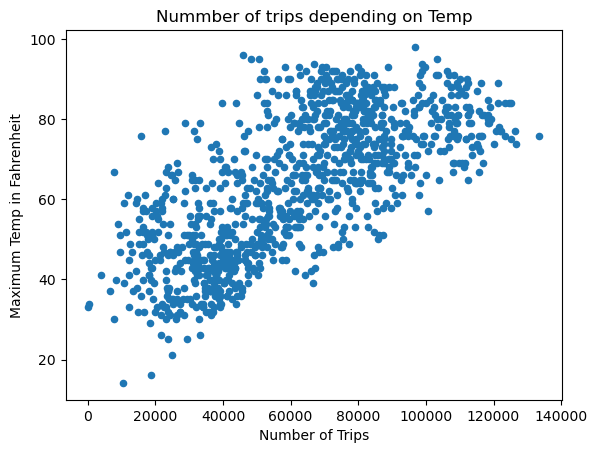

In [18]:
#plotting amount of trips against the max temp.
citibike.plot.scatter(x = 'num_of_trips', y = 'tmax')

plt.title('Nummber of trips depending on Temp')
plt.xlabel('Number of Trips')
plt.ylabel('Maximum Temp in Fahrenheit')

plt.show()

In [19]:
citibike['tmax'].describe()

count    1095.000000
mean       63.623616
std        17.404863
min        14.180000
25%        48.920000
50%        64.940000
75%        78.980000
max        98.060000
Name: tmax, dtype: float64

In [20]:
#is the tempertaure and num of trips correlated.
citibike[['num_of_trips', 'tmax']].corr()

,num_of_trips,tmax
num_of_trips,1.000000,0.705148
tmax,0.705148,1.000000


linear Regression Time 

In [21]:
#linear regression number of trips & tmax.

lm = smf.ols('num_of_trips ~ tmax', data = citibike).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_of_trips   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     1081.
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          2.14e-165
Time:                        20:09:07   Log-Likelihood:                -12389.
No. Observations:                1095   AIC:                         2.478e+04
Df Residuals:                    1093   BIC:                         2.479e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.028e+04   2273.928     -4.522      0.000   -1.47e+04   -5820.719
tmax        1133.4655     34.475     32.878      0.000    1065.821    1201.110
==============================================================================
Omnibus:                        0.207   Durbin-Watson:                   0.662
Prob(Omnibus):                  0.902   Jarque-Bera (JB):                0.279
Skew:                           0.020   Prob(JB):                        0.870
Kurtosis:                       2.933   Cond. No.                         250.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

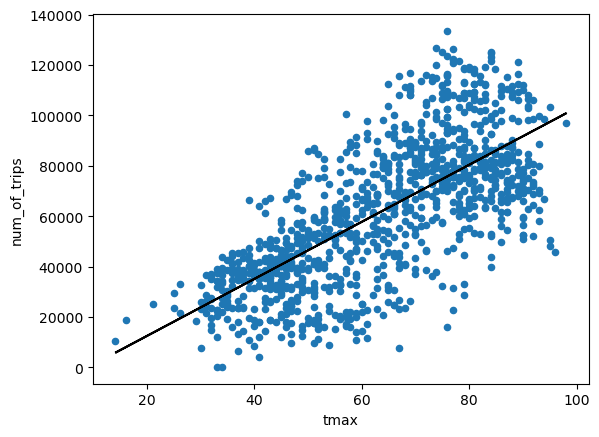

In [22]:
citibike.plot(x = 'tmax', y = 'num_of_trips', kind = 'scatter')
plt.plot(citibike['tmax'], lm.fittedvalues, color = 'black');

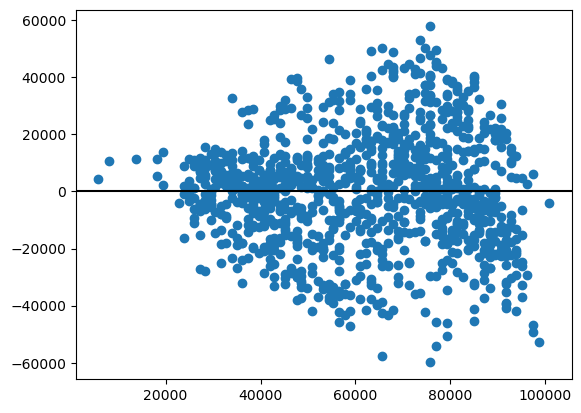

In [23]:
plt.scatter(lm.fittedvalues, lm.resid)
xmin, xmax = plt.xlim()
plt.hlines(y = 0, xmin = xmin, xmax = xmax, color = 'black')
plt.xlim(xmin, xmax);

In [24]:
lm_quad = smf.ols('num_of_trips ~ tmax + I(tmax**2)', data = citibike).fit()
lm_quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_of_trips   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     551.3
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          3.05e-166
Time:                        20:09:07   Log-Likelihood:                -12383.
No. Observations:                1095   AIC:                         2.477e+04
Df Residuals:                    1092   BIC:                         2.479e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -3.477e+04   7598.876     -4.576      0.000   -4.97e+04   -1.99e+04
tmax          1990.5308    256.172      7.770      0.000    1487.885    2493.176
I(tmax ** 2)    -6.9046      2.045     -3.376      0.001     -10.918      -2.892
==============================================================================
Omnibus:                        0.437   Durbin-Watson:                   0.685
Prob(Omnibus):                  0.804   Jarque-Bera (JB):                0.510
Skew:                          -0.039   Prob(JB):                        0.775
Kurtosis:                       2.929   Cond. No.                     6.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

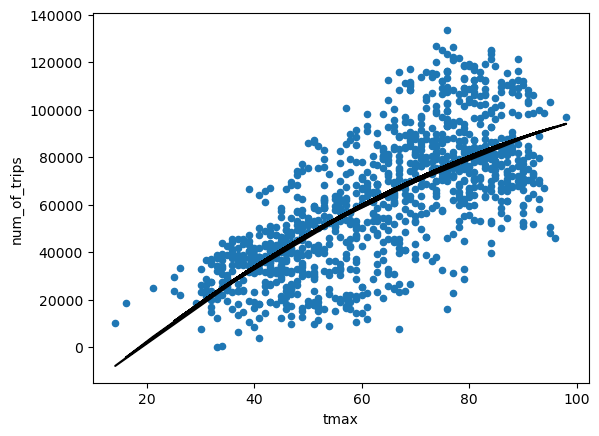

In [25]:
citibike.plot(x = 'tmax', y = 'num_of_trips', kind = 'scatter')
plt.plot(citibike['tmax'], lm_quad.fittedvalues, color = 'black');

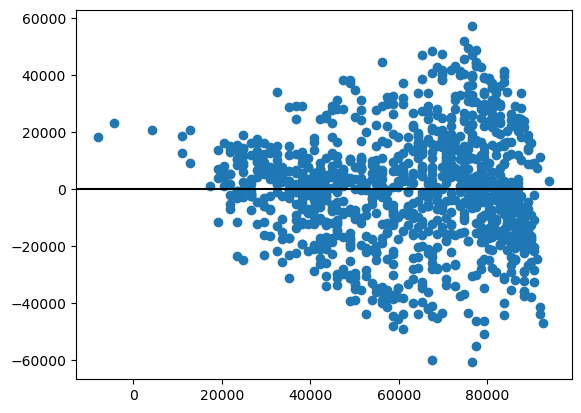

In [26]:
plt.scatter(lm_quad.fittedvalues, lm_quad.resid)
xmin, xmax = plt.xlim()
plt.hlines(y = 0, xmin = xmin, xmax = xmax, color = 'black')
plt.xlim(xmin, xmax);

In [27]:
#log linear regression number of trips & tmax.

lm_log = smf.ols('np.log(num_of_trips) ~ tmax', data = citibike).fit()
lm_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(num_of_trips)   R-squared:                       0.429
Model:                              OLS   Adj. R-squared:                  0.429
Method:                   Least Squares   F-statistic:                     822.8
Date:                  Tue, 11 Jun 2024   Prob (F-statistic):          2.32e-135
Time:                          20:09:07   Log-Likelihood:                -679.90
No. Observations:                  1095   AIC:                             1364.
Df Residuals:                      1093   BIC:                             1374.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4681      0.052    183.379      0.000       9.367       9.569
tmax           0.0225      0.001     28.685      0.000       0.021       0.024
==============================================================================
Omnibus:                      830.430   Durbin-Watson:                   0.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30974.388
Skew:                          -3.089   Prob(JB):                         0.00
Kurtosis:                      28.312   Cond. No.                         250.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

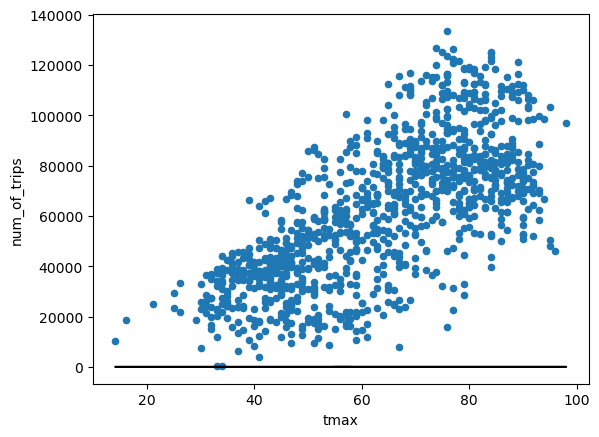

In [28]:
citibike.plot(x = 'tmax', y = 'num_of_trips', kind = 'scatter')
plt.plot(citibike['tmax'], lm_log.fittedvalues, color = 'black');

In [29]:
lm = smf.ols('num_of_trips ~ + season + day_of_week + tmax + I(tmax**2)', data = citibike).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_of_trips   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     136.5
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          1.07e-195
Time:                        20:09:08   Log-Likelihood:                -12289.
No. Observations:                1095   AIC:                         2.460e+04
Df Residuals:                    1083   BIC:                         2.466e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -6247.5495   8804.678     -0.710      0.478   -2.35e+04     1.1e+04
season[T.Spring] -1.957e+04   1571.605    -12.454      0.000   -2.27e+04   -1.65e+04
season[T.Summer] -1.436e+04   2050.811     -7.004      0.000   -1.84e+04   -1.03e+04
season[T.Winter] -1.582e+04   2036.468     -7.767      0.000   -1.98e+04   -1.18e+04
day_of_week[T.1]  5179.5171   2062.522      2.511      0.012    1132.524    9226.510
day_of_week[T.2]  5879.0381   2058.137      2.856      0.004    1840.650    9917.427
day_of_week[T.3]  3384.6613   2058.358      1.644      0.100    -654.161    7423.483
day_of_week[T.4]  4404.0060   2058.229      2.140      0.033     365.439    8442.573
day_of_week[T.5]  5710.9057   2061.258      2.771      0.006    1666.393    9755.418
day_of_week[T.6] -2513.4444   2062.044     -1.219      0.223   -6559.499    1532.610
tmax              1387.9867    278.962      4.976      0.000     840.619    1935.355
I(tmax ** 2)        -2.5118      2.266     -1.108      0.268      -6.958       1.935
==============================================================================
Omnibus:                        1.541   Durbin-Watson:                   0.754
Prob(Omnibus):                  0.463   Jarque-Bera (JB):                1.474
Skew:                          -0.089   Prob(JB):                        0.479
Kurtosis:                       3.028   Cond. No.                     7.88e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
lm = smf.ols('num_of_trips ~ + season + day_of_week + tmax  + holiday + did_rain + awnd + rhav + rhmx + rhmn + tavg + event_happened + C(month) + C(year)', data = citibike).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_of_trips   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     131.5
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          8.99e-301
Time:                        20:09:08   Log-Likelihood:                -10420.
No. Observations:                 961   AIC:                         2.090e+04
Df Residuals:                     932   BIC:                         2.104e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               2.113e+04   4217.444      5.010      0.000    1.29e+04    2.94e+04
season[T.Spring]       -5995.1634    827.778     -7.242      0.000   -7619.687   -4370.639
season[T.Summer]       -1340.8802   1521.403     -0.881      0.378   -4326.653    1644.893
season[T.Winter]       -6631.4668   1778.845     -3.728      0.000   -1.01e+04   -3140.462
day_of_week[T.1]        3714.8349   1543.816      2.406      0.016     685.077    6744.592
day_of_week[T.2]        4697.0433   1532.413      3.065      0.002    1689.664    7704.422
day_of_week[T.3]        3360.6047   1533.896      2.191      0.029     350.314    6370.895
day_of_week[T.4]        4656.8893   1524.809      3.054      0.002    1664.433    7649.345
day_of_week[T.5]        3783.4706   1548.898      2.443      0.015     743.740    6823.202
day_of_week[T.6]       -3672.6823   1548.900     -2.371      0.018   -6712.419    -632.946
holiday[T.True]        -1.111e+04   2494.373     -4.453      0.000    -1.6e+04   -6211.312
did_rain[T.True]       -8325.5645   1183.222     -7.036      0.000   -1.06e+04   -6003.476
event_happened[T.True]  4346.0997   5767.990      0.753      0.451   -6973.653    1.57e+04
C(month)[T.2]          -4771.4149   2377.588     -2.007      0.045   -9437.461    -105.368
C(month)[T.3]          -5900.2146   1227.402     -4.807      0.000   -8309.006   -3491.423
C(month)[T.4]          -4189.3028   1147.391     -3.651      0.000   -6441.071   -1937.534
C(month)[T.5]           4094.3540   1300.476      3.148      0.002    1542.153    6646.555
C(month)[T.6]           2153.4550   1257.976      1.712      0.087    -315.339    4622.249
C(month)[T.7]          -4758.8270   1251.504     -3.802      0.000   -7214.919   -2302.735
C(month)[T.8]           1264.4918   1227.149      1.030      0.303   -1143.803    3672.787
C(month)[T.9]           1.304e+04   1942.533      6.714      0.000    9229.473    1.69e+04
C(month)[T.10]          1.683e+04   1602.667     10.503      0.000    1.37e+04       2e+04
C(month)[T.11]          5221.2901   1304.115      4.004      0.000    2661.948    7780.633
C(month)[T.12]          4040.7665   2159.890      1.871      0.062    -198.046    8279.579
C(year)[T.2020]        -2093.1704   1051.177     -1.991      0.047   -4156.119     -30.222
C(year)[T.2021]         1.953e+04   1038.822     18.804      0.000    1.75e+04    2.16e+04
tmax                     217.3282    206.634      1.052      0.293    -188.194     622.851
awnd                    -342.0967     47.369     -7.222      0.000    -435.059    -249.134
rhav                    -539.2509     95.570     -5.642      0.000    -726.807    -351.695
rhmx                     196.8656     61.879      3.181      0.002      75.426     318.305
rhmn                      57.0596     65.830      0.867      0.386     -72.132  

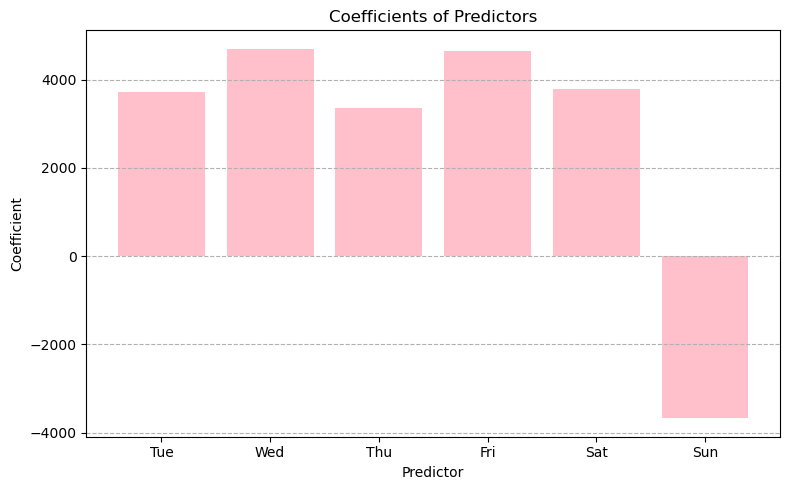

In [31]:
#Graphing day of the week coefficients when controling for season, max temp, a holiday, & rain
predictors = ['day_of_week[T.1]', 'day_of_week[T.2]', 'day_of_week[T.3]', 'day_of_week[T.4]', 'day_of_week[T.5]', 'day_of_week[T.6]']
coef = lm.params
coeffs = coef[predictors]

plt.figure(figsize=(8, 5))
plt.bar(predictors, coeffs, color=('pink'))
plt.xlabel('Predictor')
plt.ylabel('Coefficient')
plt.title('Coefficients of Predictors')
plt.xticks(ticks=range(6), labels=['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.grid(axis='y',linestyle='--')
plt.tight_layout()
plt.show()

In [32]:
coeffs

day_of_week[T.1]    3714.834930
day_of_week[T.2]    4697.043304
day_of_week[T.3]    3360.604674
day_of_week[T.4]    4656.889268
day_of_week[T.5]    3783.470582
day_of_week[T.6]   -3672.682285
dtype: float64

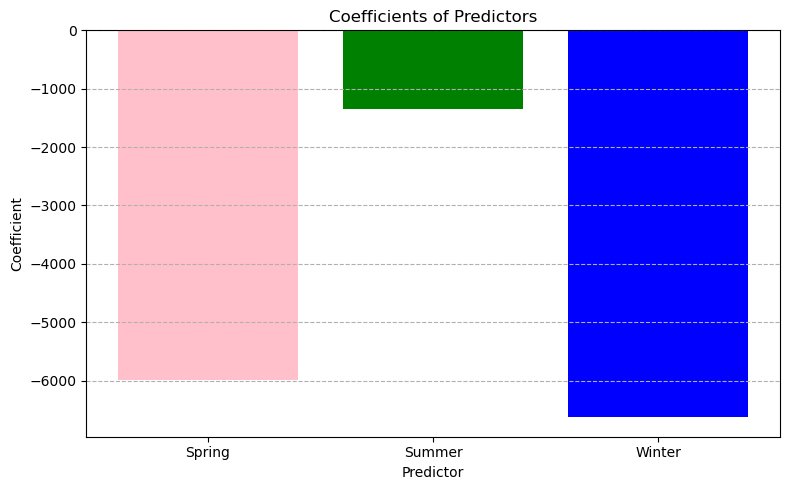

In [33]:
#Graphing the season coefficients when controling for day of week, max temp, a holiday, & rain

predictors = ['season[T.Spring]', 'season[T.Summer]', 'season[T.Winter]']
coef = lm.params
coeffs = coef[predictors]

plt.figure(figsize=(8, 5))
plt.bar(predictors, coeffs, color=['pink', 'green', 'blue'])
plt.xlabel('Predictor')
plt.ylabel('Coefficient')
plt.title('Coefficients of Predictors')
plt.xticks(ticks=range(3), labels=['Spring', 'Summer', 'Winter'], rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

***Full & Reduced Models***

In [34]:
#Adding Season
lr_reduced = smf.ols('num_of_trips ~ + tmax', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1093.0,4.305080e+11,0.0,NaN,NaN,NaN
1,1090.0,3.688953e+11,3.0,6.161272e+10,60.683762,2.777032e-36


In [35]:
#Addu=ing year as a catergory
lr_reduced = smf.ols('num_of_trips ~ + tmax + season', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year)', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1090.0,3.688953e+11,0.0,NaN,NaN,NaN
1,1088.0,2.607745e+11,2.0,1.081208e+11,225.550055,1.129646e-82


In [36]:
#Adding day of week
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year)', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1088.0,2.607745e+11,0.0,NaN,NaN,NaN
1,1082.0,2.510737e+11,6.0,9.700804e+09,6.967589,2.775217e-07


In [37]:
#adding holiday
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1082.0,2.510737e+11,0.0,NaN,NaN,NaN
1,1081.0,2.470549e+11,1.0,4.018837e+09,17.584608,0.00003


In [38]:
#adding prcp
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1081.0,2.470549e+11,0.0,NaN,NaN,NaN
1,1080.0,1.979435e+11,1.0,4.911139e+10,267.956788,5.729733e-54


In [39]:
#adding snow
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1080.0,1.979435e+11,0.0,NaN,NaN,NaN
1,1079.0,1.977156e+11,1.0,2.278473e+08,1.243438,0.265058


In [40]:
#Adding Month
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month)', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1079.0,1.977156e+11,0.0,NaN,NaN,NaN
1,1071.0,1.865455e+11,8.0,1.117018e+10,8.016317,1.532550e-10


In [41]:
#adding wind
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month)', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1071.0,1.865455e+11,0.0,NaN,NaN,NaN
1,947.0,1.609703e+11,124.0,2.557516e+10,1.213391,0.066618


In [42]:
#adding avg humidity 
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,947.0,1.609703e+11,0.0,NaN,NaN,NaN
1,935.0,1.428841e+11,12.0,1.808618e+10,9.862644,2.374160e-18


In [43]:
#adding min humidity 
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd + rhav', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav + rhmn', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,935.0,1.428841e+11,0.0,NaN,NaN,NaN
1,934.0,1.427622e+11,1.0,1.219465e+08,0.797817,0.371977


In [44]:
#adding max humidity 
lr_reduced = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd + rhav + rhmn', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~ + tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav + rhmn + rhmx', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,934.0,1.427622e+11,0.0,NaN,NaN,NaN
1,933.0,1.427340e+11,1.0,2.818205e+07,0.184216,0.667874


In [45]:
#adding avg temp
lr_reduced = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd + rhav + rhmn + rhmx', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav + rhmn + rhmx + tavg', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,933.0,1.427340e+11,0.0,NaN,NaN,NaN
1,932.0,1.410862e+11,1.0,1.647792e+09,10.885131,0.001006


In [46]:
#adding event happened
lr_reduced = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd + rhav + rhmn + rhmx + tavg', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav + rhmn + rhmx + tavg + event_happened ', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,932.0,1.410862e+11,0.0,NaN,NaN,NaN
1,931.0,1.410687e+11,1.0,1.747798e+07,0.115348,0.734212


In [47]:
#adding if it rained
lr_reduced = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd + rhav + rhmn + rhmx + tavg + event_happened', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav + rhmn + rhmx + tavg + event_happened + did_rain ', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,931.0,1.410687e+11,0.0,NaN,NaN,NaN
1,930.0,1.373588e+11,1.0,3.709961e+09,25.118628,6.452454e-07


In [48]:
#adding if snowed
lr_reduced = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd + rhav + rhmn + rhmx + tavg + event_happened + did_rain', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav + rhmn + rhmx + tavg + event_happened + did_rain + is_snow', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,930.0,1.373588e+11,0.0,NaN,NaN,NaN
1,929.0,1.372743e+11,1.0,8.450658e+07,0.571896,0.449698


In [49]:
#adding min temp
lr_reduced = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + + C(month) + awnd + rhav + rhmn + rhmx + tavg + event_happened + did_rain + is_snow', data = citibike).fit()
lr_full = smf.ols('num_of_trips ~  tmax + season + C(year) + day_of_week + holiday + prcp + snow + C(month) + awnd + rhav + rhmn + rhmx + tavg + event_happened + did_rain + is_snow + tmin', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,929.0,1.372743e+11,0.0,NaN,NaN,NaN
1,929.0,1.372743e+11,-0.0,-0.000076,inf,NaN


In [50]:
citibike.head(1)

,date,num_of_trips,holiday,prcp,snow,awnd,rhav,rhmn,rhmx,tmax,tmin,tavg,median_trip_duration,mean_trip_duration,day_of_week,year,month,is_snow,did_rain,season,event_happened
0,2019-01-01,21962,True,15,0.0,NaN,69.0,47.0,97.0,57.92,39.02,48.47,663.0,1175.93,1,2019,1,False,True,Winter,False


***correlations***

In [51]:
citibike.select_dtypes(include=['number']).corr()

,num_of_trips,prcp,snow,awnd,rhav,rhmn,rhmx,tmax,tmin,tavg,median_trip_duration,mean_trip_duration,year,month
num_of_trips,1.000000,-0.186507,-0.159288,-0.468096,-0.013585,0.011456,0.028397,0.705148,0.689595,0.705540,0.278428,0.194310,0.286513,0.347923
prcp,-0.186507,1.000000,0.151840,0.097745,0.403763,0.307399,0.350660,0.056548,0.087003,0.071896,-0.142206,-0.059920,0.018265,0.033162
snow,-0.159288,0.151840,1.000000,0.172752,0.079586,0.059393,0.076247,-0.151351,-0.143582,-0.149294,-0.085701,0.104569,0.022205,-0.056983
awnd,-0.468096,0.097745,0.172752,1.000000,-0.223436,-0.165424,-0.200322,-0.503938,-0.509769,-0.512876,-0.241827,-0.156441,0.062445,-0.147743
rhav,-0.013585,0.403763,0.079586,-0.223436,1.000000,0.875197,0.847178,0.219053,0.340240,0.280028,-0.065307,0.007834,-0.004495,0.204702
rhmn,0.011456,0.307399,0.059393,-0.165424,0.875197,1.000000,0.617281,0.128835,0.278966,0.202779,-0.120243,-0.038884,0.049342,0.227756
rhmx,0.028397,0.350660,0.076247,-0.200322,0.847178,0.617281,1.000000,0.285222,0.352433,0.320870,0.015766,0.074774,-0.036797,0.161161
tmax,0.705148,0.056548,-0.151351,-0.503938,0.219053,0.128835,0.285222,1.000000,0.955806,0.989861,0.537176,0.446584,0.029237,0.248213
tmin,0.689595,0.087003,-0.143582,-0.509769,0.340240,0.278966,0.352433,0.955806,1.000000,0.987874,0.480673,0.404989,0.037367,0.299236
tavg,0.705540,0.071896,-0.149294,-0.512876,0.280028,0.202779,0.320870,0.989861,0.987874,1.000000,0.515901,0.431496,0.033493,0.275646


**linear regression: Median Trip Duration.**

In [52]:
lm = smf.ols('median_trip_duration ~ tmax', data = citibike).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     median_trip_duration   R-squared:                       0.289
Model:                              OLS   Adj. R-squared:                  0.288
Method:                   Least Squares   F-statistic:                     443.3
Date:                  Tue, 11 Jun 2024   Prob (F-statistic):           7.01e-83
Time:                          20:09:09   Log-Likelihood:                -6905.3
No. Observations:                  1095   AIC:                         1.381e+04
Df Residuals:                      1093   BIC:                         1.382e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    364.5093     15.206     23.972      0.000     334.674     394.345
tmax           4.8538      0.231     21.055      0.000       4.401       5.306
==============================================================================
Omnibus:                      400.955   Durbin-Watson:                   0.568
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1496.785
Skew:                           1.754   Prob(JB):                         0.00
Kurtosis:                       7.527   Cond. No.                         250.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

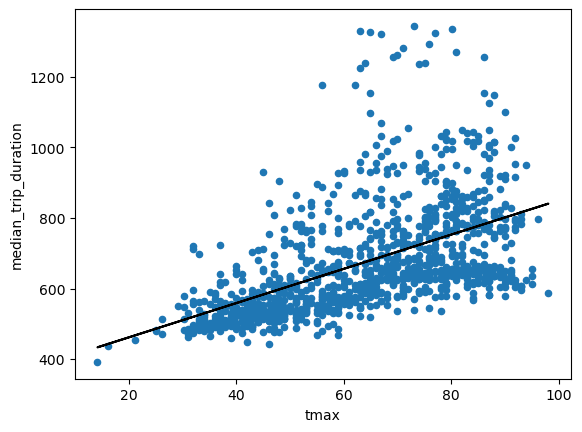

In [53]:
citibike.plot(x = 'tmax', y = 'median_trip_duration', kind = 'scatter')
plt.plot(citibike['tmax'], lm.fittedvalues, color = 'black');

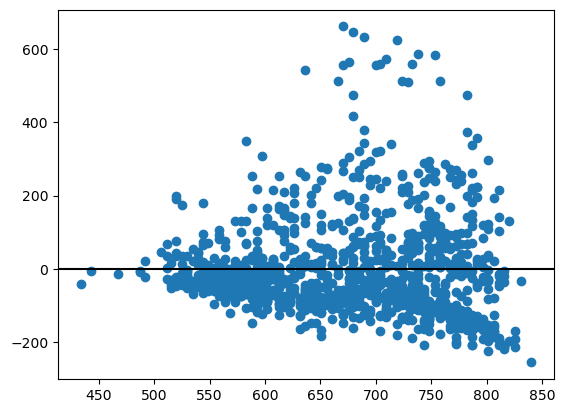

In [54]:
plt.scatter(lm.fittedvalues, lm.resid)
xmin, xmax = plt.xlim()
plt.hlines(y = 0, xmin = xmin, xmax = xmax, color = 'black')
plt.xlim(xmin, xmax);

In [55]:
citibike.columns

Index(['date', 'num_of_trips', 'holiday', 'prcp', 'snow', 'awnd', 'rhav',
       'rhmn', 'rhmx', 'tmax', 'tmin', 'tavg', 'median_trip_duration',
       'mean_trip_duration', 'day_of_week', 'year', 'month', 'is_snow',
       'did_rain', 'season', 'event_happened'],
      dtype='object')

In [56]:
citibike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 0 to 1094
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1095 non-null   datetime64[ns]
 1   num_of_trips          1095 non-null   int64         
 2   holiday               1095 non-null   bool          
 3   prcp                  1095 non-null   int64         
 4   snow                  1095 non-null   float64       
 5   awnd                  972 non-null    float64       
 6   rhav                  1084 non-null   float64       
 7   rhmn                  1084 non-null   float64       
 8   rhmx                  1084 non-null   float64       
 9   tmax                  1095 non-null   float64       
 10  tmin                  1095 non-null   float64       
 11  tavg                  1095 non-null   float64       
 12  median_trip_duration  1095 non-null   float64       
 13  mean_trip_duration

In [57]:
citibike.columns

Index(['date', 'num_of_trips', 'holiday', 'prcp', 'snow', 'awnd', 'rhav',
       'rhmn', 'rhmx', 'tmax', 'tmin', 'tavg', 'median_trip_duration',
       'mean_trip_duration', 'day_of_week', 'year', 'month', 'is_snow',
       'did_rain', 'season', 'event_happened'],
      dtype='object')

In [58]:
#using all statistically significant features.

lm_med_len = smf.ols('median_trip_duration ~ tmax + tavg + awnd + season + year + C(month) + holiday + did_rain + is_snow + day_of_week + rhav', data = citibike).fit()
lm_med_len.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     median_trip_duration   R-squared:                       0.477
Model:                              OLS   Adj. R-squared:                  0.464
Method:                   Least Squares   F-statistic:                     34.18
Date:                  Tue, 11 Jun 2024   Prob (F-statistic):          1.46e-113
Time:                          20:09:09   Log-Likelihood:                -5824.0
No. Observations:                   961   AIC:                         1.170e+04
Df Residuals:                       935   BIC:                         1.183e+04
Df Model:                            25                                         
Covariance Type:              nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -2.177e+04   7352.749     -2.960      0.003   -3.62e+04   -7335.220
season[T.Spring] -2932.6765   1002.532     -2.925      0.004   -4900.151    -965.202
season[T.Summer] -2961.7710   1002.242     -2.955      0.003   -4928.675    -994.867
season[T.Winter] -4009.0596   1339.201     -2.994      0.003   -6637.248   -1380.872
C(month)[T.2]       -9.3537     19.885     -0.470      0.638     -48.378      29.671
C(month)[T.3]    -1016.5154    334.813     -3.036      0.002   -1673.588    -359.443
C(month)[T.4]     -949.1505    334.041     -2.841      0.005   -1604.708    -293.593
C(month)[T.5]     -967.0106    334.123     -2.894      0.004   -1622.728    -311.293
C(month)[T.6]     -984.6963    334.269     -2.946      0.003   -1640.701    -328.692
C(month)[T.7]     -988.8705    334.192     -2.959      0.003   -1644.723    -333.018
C(month)[T.8]     -988.2041    334.183     -2.957      0.003   -1644.040    -332.369
C(month)[T.9]    -3927.4988   1335.701     -2.940      0.003   -6548.819   -1306.179
C(month)[T.10]   -3951.9276   1336.595     -2.957      0.003   -6575.001   -1328.855
C(month)[T.11]   -3982.0882   1336.787     -2.979      0.003   -6605.539   -1358.638
C(month)[T.12]      14.6810     18.018      0.815      0.415     -20.679      50.041
holiday[T.True]     67.9338     20.844      3.259      0.001      27.028     108.840
did_rain[T.True]   -36.7057      9.330     -3.934      0.000     -55.016     -18.395
is_snow[T.True]     61.4447     26.907      2.284      0.023       8.639     114.250
day_of_week[T.1]     9.8496     12.862      0.766      0.444     -15.393      35.092
day_of_week[T.2]     5.2703     12.776      0.413      0.680     -19.802      30.343
day_of_week[T.3]     9.3577     12.786      0.732      0.464     -15.734      34.450
day_of_week[T.4]    22.7527     12.754      1.784      0.075      -2.278      47.783
day_of_week[T.5]   139.8304     12.930     10.814      0.000     114.455     165.206
day_of_week[T.6]   116.1566     12.871      9.025      0.000      90.897     141.416
tmax                 5.0705      1.672      3.032      0.002       1.788       8.353
tavg                -1.8196      1.985     -0.917      0.360      -5.715       2.076
awnd                -0.3071      0.393     -0.781      0.435      -1.079       0.465
year                12.9602      4.302      3.013      0.003       4.518      21.403
rhav                -0.5963      0.335     -1.780      0.075      -1.254       0.061
==============================================================================
Omnibus:                      239.974   Durbin-Watson:                   0.435
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              594.195
Skew:                           1.312   Prob(JB):                    9.38e-130
Kurtosis:                

In [59]:
#using all features even the ones that are not statistically significant

lm_med_len = smf.ols('median_trip_duration ~ tmax + tmin + tavg+ prcp + snow + awnd + season + year + C(month) + holiday + did_rain + is_snow + day_of_week + rhav + rhmn + rhmx + event_happened', data = citibike).fit()
lm_med_len.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     median_trip_duration   R-squared:                       0.493
Model:                              OLS   Adj. R-squared:                  0.477
Method:                   Least Squares   F-statistic:                     30.15
Date:                  Tue, 11 Jun 2024   Prob (F-statistic):          1.06e-115
Time:                          20:09:09   Log-Likelihood:                -5809.5
No. Observations:                   961   AIC:                         1.168e+04
Df Residuals:                       930   BIC:                         1.183e+04
Df Model:                            30                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -2.562e+04   7327.480     -3.496      0.000      -4e+04   -1.12e+04
season[T.Spring]       -3459.8362    999.159     -3.463      0.001   -5420.703   -1498.969
season[T.Summer]       -3484.5013    998.744     -3.489      0.001   -5444.555   -1524.448
season[T.Winter]       -4713.3254   1334.659     -3.531      0.000   -7332.619   -2094.032
C(month)[T.2]            -11.8945     19.767     -0.602      0.547     -50.687      26.898
C(month)[T.3]          -1191.3565    333.720     -3.570      0.000   -1846.289    -536.424
C(month)[T.4]          -1126.8106    332.960     -3.384      0.001   -1780.251    -473.370
C(month)[T.5]          -1141.6691    332.916     -3.429      0.001   -1795.022    -488.316
C(month)[T.6]          -1160.8221    333.195     -3.484      0.001   -1814.724    -506.920
C(month)[T.7]          -1161.5028    332.975     -3.488      0.001   -1814.972    -508.033
C(month)[T.8]          -1162.1765    332.971     -3.490      0.001   -1815.638    -508.715
C(month)[T.9]          -4625.1510   1331.034     -3.475      0.001   -7237.330   -2012.972
C(month)[T.10]         -4653.1156   1331.948     -3.493      0.000   -7267.088   -2039.143
C(month)[T.11]         -4683.8526   1332.240     -3.516      0.000   -7298.397   -2069.308
C(month)[T.12]            15.1407     17.815      0.850      0.396     -19.821      50.102
holiday[T.True]           69.4575     20.606      3.371      0.001      29.017     109.898
did_rain[T.True]         -37.7068     10.114     -3.728      0.000     -57.556     -17.858
is_snow[T.True]           34.9902     31.710      1.103      0.270     -27.242      97.222
day_of_week[T.1]          11.3941     12.765      0.893      0.372     -13.657      36.445
day_of_week[T.2]           7.1066     12.664      0.561      0.575     -17.747      31.961
day_of_week[T.3]          12.2683     12.671      0.968      0.333     -12.598      37.135
day_of_week[T.4]          21.8772     12.620      1.734      0.083      -2.890      46.644
day_of_week[T.5]         142.0872     12.806     11.095      0.000     116.955     167.219
day_of_week[T.6]         118.3663     12.814      9.237      0.000      93.218     143.514
event_happened[T.True]   -34.1653     47.602     -0.718      0.473    -127.586      59.255
tmax                       3.0047      0.805      3.733      0.000       1.425       4.584
tmin                      -0.9539      0.947     -1.008      0.314      -2.812       0.904
tavg                       1.0254      0.195      5.258      0.000       0.643       1.408
prcp                      -0.1398      0.036     -3.831      0.000      -0.211      -0.068
snow                       0.2508      0.285      0.880      0.379      -0.308       0.810
awnd                      -0.0301      0.400     -0.075   

In [60]:
coef.keys()

Index(['Intercept', 'season[T.Spring]', 'season[T.Summer]', 'season[T.Winter]',
       'day_of_week[T.1]', 'day_of_week[T.2]', 'day_of_week[T.3]',
       'day_of_week[T.4]', 'day_of_week[T.5]', 'day_of_week[T.6]',
       'holiday[T.True]', 'did_rain[T.True]', 'event_happened[T.True]',
       'C(month)[T.2]', 'C(month)[T.3]', 'C(month)[T.4]', 'C(month)[T.5]',
       'C(month)[T.6]', 'C(month)[T.7]', 'C(month)[T.8]', 'C(month)[T.9]',
       'C(month)[T.10]', 'C(month)[T.11]', 'C(month)[T.12]', 'C(year)[T.2020]',
       'C(year)[T.2021]', 'tmax', 'awnd', 'rhav', 'rhmx', 'rhmn', 'tavg'],
      dtype='object')

In [61]:
coeffs

season[T.Spring]   -5995.163441
season[T.Summer]   -1340.880218
season[T.Winter]   -6631.466778
dtype: float64

In [62]:
predictors

['season[T.Spring]', 'season[T.Summer]', 'season[T.Winter]']

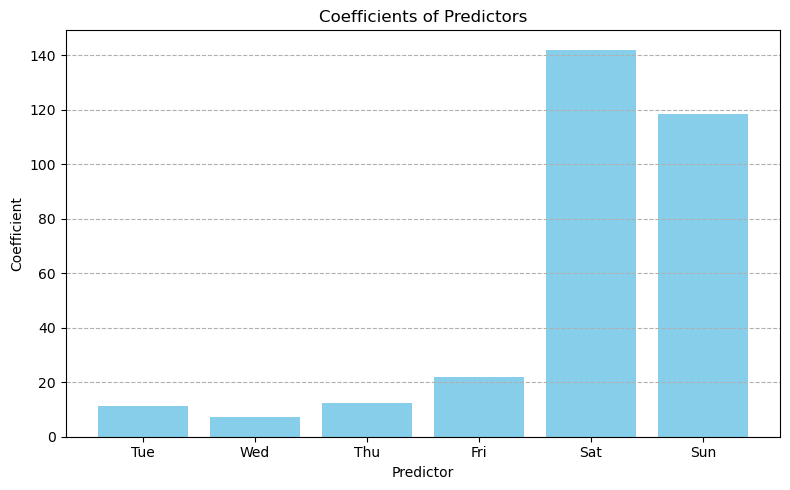

In [63]:
#Graphing day of the week coefficients when controling for season, max temp, a holiday, & rain
predictors = ['day_of_week[T.1]', 'day_of_week[T.2]', 'day_of_week[T.3]', 'day_of_week[T.4]', 'day_of_week[T.5]', 'day_of_week[T.6]']
coef = lm_med_len.params
coeffs = coef[predictors]

plt.figure(figsize=(8, 5))
plt.bar(predictors, coeffs, color=('skyblue'))
plt.xlabel('Predictor')
plt.ylabel('Coefficient')
plt.title('Coefficients of Predictors')
plt.xticks(ticks=range(6), labels=['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.grid(axis='y',linestyle='--')
plt.tight_layout()
plt.show()

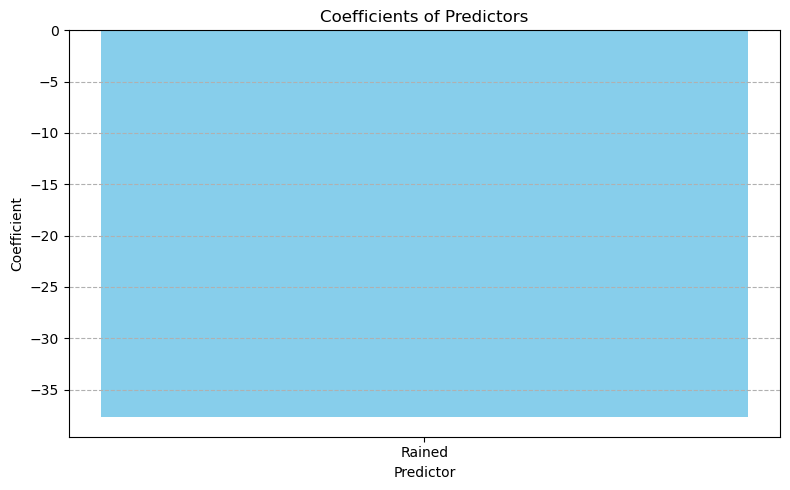

In [64]:
predictors = ['did_rain[T.True]']
coef = lm_med_len.params
coeffs = coef[predictors]

plt.figure(figsize=(8, 5))
plt.bar(predictors, coeffs, color=('skyblue'))
plt.xlabel('Predictor')
plt.ylabel('Coefficient')
plt.title('Coefficients of Predictors')
plt.xticks(ticks=range(1), labels=['Rained'], rotation=0)
plt.grid(axis='y',linestyle='--')
plt.tight_layout()
plt.show()

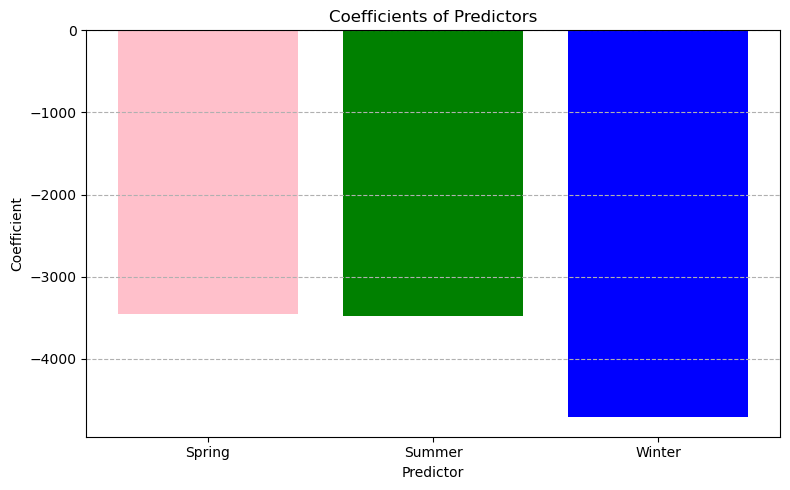

In [65]:
predictors = ['season[T.Spring]', 'season[T.Summer]', 'season[T.Winter]']
coef = lm_med_len.params
coeffs = coef[predictors]

plt.figure(figsize=(8, 5))
plt.bar(predictors, coeffs, color=['pink', 'green', 'blue'])
plt.xlabel('Predictor')
plt.ylabel('Coefficient')
plt.title('Coefficients of Predictors')
plt.xticks(ticks=range(3), labels=['Spring', 'Summer', 'Winter'], rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [66]:
lm = smf.ols('median_trip_duration ~ tmax', data = citibike).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     median_trip_duration   R-squared:                       0.289
Model:                              OLS   Adj. R-squared:                  0.288
Method:                   Least Squares   F-statistic:                     443.3
Date:                  Tue, 11 Jun 2024   Prob (F-statistic):           7.01e-83
Time:                          20:09:10   Log-Likelihood:                -6905.3
No. Observations:                  1095   AIC:                         1.381e+04
Df Residuals:                      1093   BIC:                         1.382e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    364.5093     15.206     23.972      0.000     334.674     394.345
tmax           4.8538      0.231     21.055      0.000       4.401       5.306
==============================================================================
Omnibus:                      400.955   Durbin-Watson:                   0.568
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1496.785
Skew:                           1.754   Prob(JB):                         0.00
Kurtosis:                       7.527   Cond. No.                         250.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
#Adding Season
lr_reduced = smf.ols('median_trip_duration ~ + tmax', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1093.0,1.925010e+07,0.0,NaN,NaN,NaN
1,1090.0,1.812434e+07,3.0,1.125757e+06,22.56771,3.529296e-14


In [68]:
#Adding year as numerical
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + year', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1090.0,1.812434e+07,0.0,NaN,NaN,NaN
1,1089.0,1.798170e+07,1.0,142642.646242,8.638663,0.00336


In [69]:
#Adding year as catergorical 
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year)', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1090.0,1.812434e+07,0.0,NaN,NaN,NaN
1,1088.0,1.206305e+07,2.0,6.061290e+06,273.342253,6.577369e-97


In [70]:
##Adding day of week
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year)', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1088.0,1.206305e+07,0.0,NaN,NaN,NaN
1,1082.0,9.232118e+06,6.0,2.830934e+06,55.297366,1.184729e-59


In [71]:
#Adding Holiday
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1082.0,9.232118e+06,0.0,NaN,NaN,NaN
1,1081.0,9.050538e+06,1.0,181579.795093,21.687966,0.000004


In [72]:
##Adding if it rained
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1081.0,9.050538e+06,0.0,NaN,NaN,NaN
1,1080.0,8.601714e+06,1.0,448824.348985,56.35276,1.264047e-13


In [73]:
#Adding if it snowed
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1080.0,8.601714e+06,0.0,NaN,NaN,NaN
1,1079.0,8.487107e+06,1.0,114606.550129,14.570391,0.000143


In [74]:
#adding Month
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month)', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1079.0,8.487107e+06,0.0,NaN,NaN,NaN
1,1071.0,7.623031e+06,8.0,864075.594,15.174819,3.065724e-21


In [75]:
#adding prcp
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month)', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1071.0,7.623031e+06,0.0,NaN,NaN,NaN
1,1070.0,7.418709e+06,1.0,204322.774578,29.469464,7.026530e-08


In [76]:
#Adding snow
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow ', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1070.0,7.418709e+06,0.0,NaN,NaN,NaN
1,1069.0,7.418485e+06,1.0,223.557967,0.032215,0.857592


In [77]:
#Adding Wind 
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1069.0,7.418485e+06,0.0,NaN,NaN,NaN
1,945.0,5.722526e+06,124.0,1.695959e+06,2.258592,9.657316e-12


In [78]:
#Adding avg humidity
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav ', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,945.0,5.722526e+06,0.0,NaN,NaN,NaN
1,933.0,5.613098e+06,12.0,109427.635635,1.51574,0.112388


In [79]:
#Adding min humidity
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,933.0,5.613098e+06,0.0,NaN,NaN,NaN
1,932.0,5.597351e+06,1.0,15747.059446,2.622001,0.10573


In [80]:
#Adding max humidity
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn + rhmx', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,932.0,5.597351e+06,0.0,NaN,NaN,NaN
1,931.0,5.579329e+06,1.0,18021.746161,3.007216,0.083226


In [81]:
#Adding min temp
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn + rhmx', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn + rhmx + tmin', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,931.0,5.579329e+06,0.0,NaN,NaN,NaN
1,930.0,5.576508e+06,1.0,2821.499157,0.470544,0.492908


In [82]:
#Adding avg temp
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn + rhmx + tmin', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn + rhmx + tmin + tavg', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,930.0,5.576508e+06,0.0,NaN,NaN,NaN
1,930.0,5.576508e+06,-0.0,-3.725290e-09,inf,NaN


In [83]:
#Adding event
lr_reduced = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn + rhmx + tmin + tavg', data = citibike).fit()
lr_full = smf.ols('median_trip_duration ~ + tmax + season + C(year) + day_of_week + holiday + did_rain + is_snow + C(month) + prcp + snow + awnd + rhav + rhmn + rhmx + tmin + tavg + event_happened', data = citibike).fit()

sm.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,930.0,5.576508e+06,0.0,NaN,NaN,NaN
1,929.0,5.576508e+06,1.0,0.111505,0.000019,0.996562


In [84]:
citibike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 0 to 1094
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1095 non-null   datetime64[ns]
 1   num_of_trips          1095 non-null   int64         
 2   holiday               1095 non-null   bool          
 3   prcp                  1095 non-null   int64         
 4   snow                  1095 non-null   float64       
 5   awnd                  972 non-null    float64       
 6   rhav                  1084 non-null   float64       
 7   rhmn                  1084 non-null   float64       
 8   rhmx                  1084 non-null   float64       
 9   tmax                  1095 non-null   float64       
 10  tmin                  1095 non-null   float64       
 11  tavg                  1095 non-null   float64       
 12  median_trip_duration  1095 non-null   float64       
 13  mean_trip_duration

In [89]:
citibike.groupby('year')['num_of_trips'].sum()

year
2019    20551697
2020    19506857
2021    27648252
Name: num_of_trips, dtype: int64

In [86]:
#  citibike.to_csv('../data/citibike_vis.csv')

In [ ]:
#citibike['is_snow'] = citibike['snow'] != 0

In [ ]:
#citibike['did_rain'] = citibike['prcp'] != 0